# Easy: Use all exogenous variables in a SARIMAX model to predict the real GDP  
In this chapter, we limited the number of exogenous variables when forecasting for the real GDP.  
This exercise is the occasion to fit a SARIMAX model using all exogenous variables and verify if we can achieve a better performance.  
• Use all exogenous variables in the SARIMAX model.  
• Perform residual analysis.  
• Produce forecast for the last 7 timesteps in the dataset.  
• Measure the MAPE. Is it better, worse, or identical to what was achieved with a limited number of exogenous variables?

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

print('timetools version: {}'.format(tt.__version__))

timetools version: 01.14.2020


### Layout of file

| Variable  | Description  |
|---|---|
| realgdp  | Real gross domestic product (the **target variable or endogenous variable**)  |
| realcons  | Real personal consumption expenditure  |
| realinv  | Real gross private domestic investment  |
| realgovt  | Real federal consumption expenditure and investment  |
| realdpi  | Real private disposable income  |
| cpi  | Consumer price index for the end of the quarter  |
| m1  | M1 nominal money stock  |
| tbilrate  | Quarterly monthly average of the monthly 3-month treasury bill  |
| unemp  | Unemployement rate  |
| pop  | Total population at the end of the qurter  |
| infl  | Inflation rate  |
| realint  | Real interest rate  |

In [8]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [9]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[macro_econ_data.columns[3:]]      # use all exogenous variables
exog = macro_econ_data[['cpi', 'unemp', 'pop']]          # use the 3 exogneous variables with the largest coefficients 

Test Statistic                   1.750463
p-value                          0.998246
#Lags Used                      12.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64

The time series is not stationary.


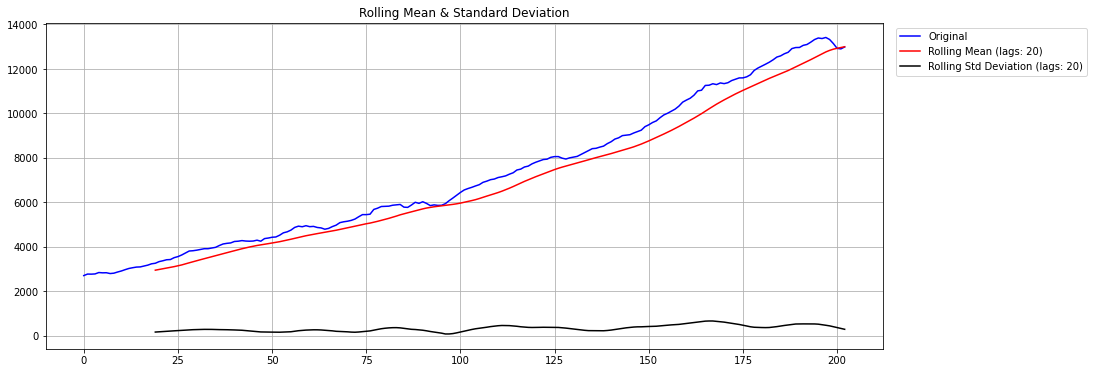

In [10]:
tt.adf(target)
tt.plot_for_stationary(target)

Test Statistic                -6.305696e+00
p-value                        3.327882e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

The time series is stationary.


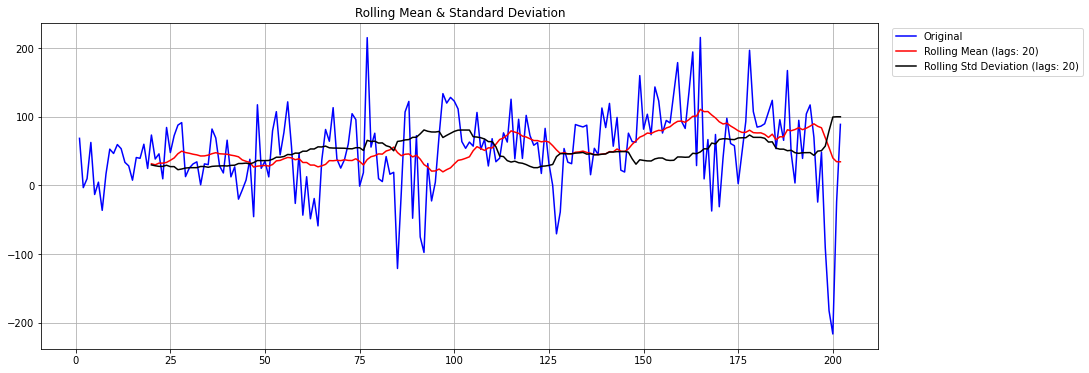

In [11]:
target_diff = target.diff(1)
tt.adf(target_diff[1:])
tt.plot_for_stationary(target_diff[1:])

In [12]:
d = 1
D = 0
s = 4
parameters_list = tt.parameters(pmax=4,qmax=4,Pmax=4,Qmax=4)
target_train = target[:200]
exog_train = exog[:200]

AttributeError: module 'timetools' has no attribute 'parameters'

In [ ]:
result_df = tt.optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
best_model = SARIMAX(target_train, exog_train, order=(4,1,4), seasonal_order=(0,0,0,4), simple_differencing=False)     # use all exogenous variables
# best_model = SARIMAX(target_train, exog_train, order=(0,1,2), seasonal_order=(2,0,2,4), simple_differencing=False)     # use the 3 exogneous variables with the largest coefficients
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH09_F05_peixeiro.png', dpi=300)

In [ ]:
residuals = best_model_fit.resid
tt.ljungbox(residuals, lags=10)

In [ ]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = tt.recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = tt.recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

In [ ]:
mape_last = tt.mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = tt.mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

In [ ]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

# plt.savefig('figures/CH09_F06_peixeiro.png', dpi=300)